# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
D = np.loadtxt('./lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [2]:
def mse(y_predicted, y_true):
    assert len(y_predicted) == len(y_true)
    return (np.sum((y_predicted - y_true)**2)) / len(y_predicted)

In [3]:
class NormalLR:
    def __init__(self, weights = np.zeros((1, 1)), theta = 0):
        # theta is regularization factor, theta = 0 by default
        self.weights = weights
        self.theta = theta
    
    def fit(self, X, y):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis = 1)

        # we will use regularization here (theta * identity matrix)
        inversed_matrix = np.linalg.inv(X.T @ X + self.theta * np.eye(X.shape[1]))
        self.weights = inversed_matrix @ X.T @ y
        
    def predict(self, X):
        X =  np.concatenate((X, np.ones((X.shape[0], 1))), axis = 1)
        return X @ self.weights

0.0


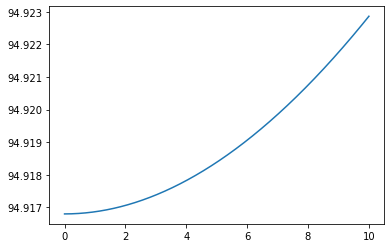

In [4]:
theta_values = np.linspace(0,10,1000)
mse_scores = []
lowest_mse = 1000000
best_theta = -1
for theta in theta_values:
    model = NormalLR(theta = theta)
    model.fit(X, Y)
    y_predicted = model.predict(X)
    current_error = mse(Y, y_predicted)
    
    if current_error < lowest_mse:
        lowest_mse = current_error
        best_theta = theta
    mse_scores.append(current_error)
    
print(best_theta)
plt.plot(theta_values, mse_scores)
plt.show()

In [5]:
def get_folds(y):
    indices = np.random.permutation(np.arange(len(y)))
    fold_size = len(y) // 5
    return [indices[:fold_size],
            indices[fold_size : 2 * fold_size],
            indices[2 * fold_size : 3 * fold_size],
            indices[3 * fold_size : 4 * fold_size],
            indices[4 * fold_size :]]

In [6]:
def validation_curve(X, y):
    list_of_folds = get_folds(y)
    fold_list = np.arange(5)
    
    errors_on_train = []
    errors_on_validation = []
    for theta in theta_values:
        
        #ошибки для текущих значений theta
        cur_tr_errors = []
        cur_val_errors = []
        
        for (i, fold) in enumerate(list_of_folds):
            #разделили данные
            tr_indeces = []
            for j in np.delete(fold_list, i):
                tr_indeces += list(list_of_folds[j])
            tr_indeces = np.asarray(tr_indeces)
            val_indeces = fold
            
            #обучили модель
            regr = NormalLR(theta=theta)
            X_train = X[tr_indeces]
            y_train = y[tr_indeces]
            regr.fit(X_train, y_train)
            
            #посчитали ошибки
            mse_on_tr = mse(regr.predict(X_train), y_train)
            val_on_val = mse(regr.predict(X[val_indeces]), y[val_indeces])
            cur_tr_errors.append(mse_on_tr)
            cur_val_errors.append(val_on_val)
            
        errors_on_train.append(np.mean(cur_tr_errors))
        errors_on_validation.append(np.mean(cur_val_errors))
        
    return errors_on_train, errors_on_validation


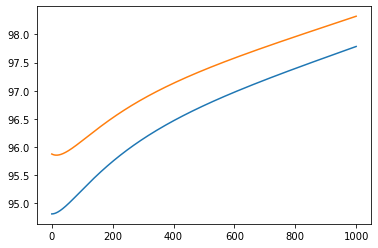

best regulization parametr is  15.14189325304352


In [7]:
theta_values = np.logspace(-3, 3, 1000)
train_errors, validation_errors = validation_curve(X, Y)
plt.figure()
plt.plot(theta_values, train_errors)
plt.plot(theta_values,  validation_errors)
plt.show()
best_validation_arror = 1000000
ind_of_best_val_er = -1
for (i, er) in enumerate(validation_errors):
    if (best_validation_arror > er):
        best_validation_arror = er
        ind_of_best_val_er = i
print('best regulization parametr is ', theta_values[ind_of_best_val_er])

In [8]:
def learning_curve(X, y, theta):
    list_of_folds = get_folds(y)
    fold_list = np.arange(5)
    
    errors_on_train = []
    errors_on_validation = []
    
    
    for ind in range(800):
        
        #ошибки для текущих значений theta
        cur_tr_errors = []
        cur_val_errors = []
        
        for (i, fold) in enumerate(list_of_folds):
            #разделили данные
            tr_indeces = []
            for j in np.delete(fold_list, i):
                tr_indeces += list(list_of_folds[j])
            tr_indeces = np.asarray(tr_indeces)
            val_indeces = fold
            
            #обучили модель
            regr = NormalLR(theta=theta)
            X_train = X[tr_indeces][:ind+1]
            y_train = y[tr_indeces][:ind+1]
            regr.fit(X_train, y_train)
            
            #посчитали ошибки
            mse_on_tr = mse(regr.predict(X_train), y_train)
            val_on_val = mse(regr.predict(X[val_indeces]), y[val_indeces])
            cur_tr_errors.append(mse_on_tr)
            cur_val_errors.append(val_on_val)
            
        errors_on_train.append(np.mean(cur_tr_errors))
        errors_on_validation.append(np.mean(cur_val_errors))
        
    return errors_on_train, errors_on_validation

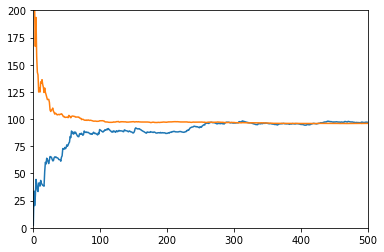

In [9]:
train_error, validat_error = learning_curve(X, Y, theta_values[ind_of_best_val_er])
max_x = 0.8 * len(X)
plt.figure()
plt.plot(np.arange(max_x), train_error)
plt.plot(np.arange(max_x),  validat_error)
plt.axis([0, 500, 0, 200])
plt.show()